<h1> Dynamic Topic Modelling using LDA </h1>

In [ ]:
# Install pyLDAvis
#!pip install pyLDAvis

In [5]:
import pandas as pd
import numpy
import pickle
import time
import gensim
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models
import csv

#from sklearn.decomposition import LatentDirichletAllocation
#from sklearn.feature_extraction.text import CountVectorizer
#from gensim.models.coherencemodel import CoherenceModel

# setting up our imports
from gensim.models import ldaseqmodel
from gensim.corpora import Dictionary, bleicorpus
from gensim.matutils import hellinger
from gensim.models.coherencemodel import CoherenceModel
#from gensim.models.wrappers.dtmmodel import DtmModel

/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<h1> 1. Load data and treat </h1>

In [6]:
# Import the final tokens
#f = open('/project/biocomplexity/sdad/projects_data/ncses/prd/Tech-Report/FR_meta_and_final_tokens_21SEPT14.pkl', 'rb')
f = open('/project/biocomplexity/sdad/projects_data/ncses/prd/Tech-Report/case_studies/coronavirus_corpus.pkl', 'rb')
df = pickle.load(f)
f.close()
df.head()

/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,index,original index,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,...,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,final_tokens
5122,5122,5608,95622,Host - virus interactions are greatly affected...,2008,Affect; Antiviral Agents; Area; Biochemical; D...,THE ROLE OF A HOST ION PUMP IN RNA VIRUS RECOM...,NSF,NSF,NaN,...,UNITED STATES,NaN,NaN,47.074,2008,612000.0,NaN,1,1,"[host, virus, interaction, greatly, affect, ex..."
13938,13938,15726,152221,AbstractThe American Society for Virology (ASV...,2008,abstracting; Acquired Immunodeficiency Syndrom...,"INTERNATIONAL CONGRESS OF VIROLOGY, ISTANBUL, ...",HHS,NIH,NIAID,...,UNITED STATES,2/1/2008,1/31/2009,93.855,2008,30000.0,NaN,1,1,"[american, society, virology_asv, wish, provid..."
14418,14418,17118,153617,DESCRIPTION (provided by applicant): Severe a...,2008,Abbreviations; Address; Alleles; Alphavirus; A...,SARS REVERSE GENETICS,HHS,NIH,NIAID,...,UNITED STATES,2/1/2008,1/31/2010,93.855,2008,271608.0,NaN,1,1,"[severe, acute, respiratory, syndrome, life_th..."
14514,14514,17384,153888,DESCRIPTION (provided by applicant): Human cor...,2008,Acute; Age-Years; Antigens; Archives; base; Bi...,EPIDEMIOLOGY AND CLINICAL FEATURES OF HUMAN CO...,HHS,NIH,NIAID,...,UNITED STATES,2/1/2008,1/31/2010,93.855,2008,75292.0,NaN,1,1,"[human, coronaviruse_hcov, initially, identify..."
14565,14565,17526,154033,"DESCRIPTION: Plus-stranded RNA viruses, which ...",2008,Affect; Agriculture; Animals; Antiviral Agents...,ROLES OF HOST RNA BINDING PROTEINS IN VIRUS RE...,HHS,NIH,NIAID,...,UNITED STATES,2/1/2008,1/31/2010,93.855,2008,200124.0,NaN,1,1,"[strand, rna, virus, pose, significant, risk, ..."


In [7]:
# Count the number of Abstracts by year. PROJECT_START_DATE doesn't have missing informations= uses it for the time slice
df.columns

/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['index', 'original index', 'PROJECT_ID', 'ABSTRACT', 'FY',
       'PROJECT_TERMS', 'PROJECT_TITLE', 'DEPARTMENT', 'AGENCY', 'IC_CENTER',
       'PROJECT_NUMBER', 'PROJECT_START_DATE', 'PROJECT_END_DATE',
       'CONTACT_PI_PROJECT_LEADER', 'OTHER_PIS', 'CONGRESSIONAL_DISTRICT',
       'DUNS_NUMBER', 'ORGANIZATION_NAME', 'ORGANIZATION_CITY',
       'ORGANIZATION_STATE', 'ORGANIZATION_ZIP', 'ORGANIZATION_COUNTRY',
       'BUDGET_START_DATE', 'BUDGET_END_DATE', 'CFDA_CODE', 'FY.y',
       'FY_TOTAL_COST', 'FY_TOTAL_COST_SUB_PROJECTS', 'ORG_COUNT', 'PI_COUNT',
       'final_tokens'],
      dtype='object')

In [8]:
# length (number of abstract) of the coronavirus sample
print(len(df), "Abstracts")

1022 Abstracts


/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# Function to compute the corpus and dictionary for the DTM LDA
def createLDAvars(docs):

    # Create the variables needed for LDA from df[final_frqwds_removed]: dictionary (id2word), corpus
    
    # Create Dictionary
    id2word = gensim.corpora.Dictionary(docs)

    #Filter words to only those found in at least a set number of documents (min_appearances)
    id2word.filter_extremes(no_below=20, no_above=0.6)
    
    # filter out stop words - "use" already filtered out by previous line
    id2word.filter_tokens(bad_ids=[id2word.token2id['research'], id2word.token2id['project']])

    # Create Corpus (Term Document Frequency)

    #Creates a count for each unique word appearing in the document, where the word_id is substituted for the word
    # corpus not need for c_v coherence
    corpus = [id2word.doc2bow(doc) for doc in docs]

    return id2word, corpus

/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# build the dictionary id2word
docs = df["final_tokens"]
[dictionary, corpus] = createLDAvars(docs)

/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
# Create the time slice using the fiscal year
df['Year'] = df['FY']
time_slice = df['PROJECT_ID'].groupby(df['Year']).count()

/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<h2> 3. Solve a dynamic topic model </h2>

In [ ]:
# Run the DMT. Pre-training model (default chain_variance=0.005)
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=time_slice, num_topics=30)

# save to file
pickle.dump(ldaseq, open('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/LDA/DTM_LDA_30.pkl','wb'))

<h3> 3.1 Run the pickle file from slurm <h3 />

In [13]:
# Load the pickle result from slurm
f = open('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/LDA/DTM_LDA_30.pkl', 'rb')
ldaseq = pickle.load(f)
f.close()

/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
# Print the list of topics a given time
topic_list = ldaseq.print_topics(time=0)
topic_words = []

for i in range(len(topic_list)):
    topic_words.append([item[0] for item in topic_list[i]])

# Print the list of topics 
pd.DataFrame(topic_words)

# Save the result in csv
with open('Topic_list_0.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(topic_words)

/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
# Time evolution of the first topic. Combine the whole time evolution in a DataFrame
time_topic = ldaseq.print_topic_times(topic=1)
time = list(time_slice.index)
topic_evol = pd.DataFrame(time_topic[0])
topic_evol.columns = ['WORDS', 'YEAR_'+str(time[0])]

for i in range(1,len(time_topic)):
    year_topic = pd.DataFrame(time_topic[i])
    year_topic.columns = ['WORDS', 'PROB_'+str(time[i])]
    topic_evol = topic_evol.merge(year_topic, how='outer', on=['WORDS'])

# Print the topic evolution. Detect some news words (max=30 words)
topic_evol.head(30)

# Save the result in csv
topic_evol.to_csv('Topic_evol_1.csv')

/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<h3> 3.2. Compute the topic coherence <h3 />

In [34]:
# Compute model coherence. Show the trend evolution and compute the golbal coherence as the average coherence over the time
coherence_values = []

for t in range(0,len(time)):
    topics_dtm = ldaseq.dtm_coherence(time=t)
    cm = CoherenceModel(topics=topics_dtm, dictionary=dictionary, texts=docs, coherence='c_v', processes=30) 
    coherence_values.append(cm.get_coherence())
    
#  Create a coherence series from the list. compute also the median....
coherence_serie = pd.Series(coherence_values, index =time)
print ("The gobal coherence is ", coherence_serie.mean())

/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The gobal coherence is  0.44078578516504213


/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


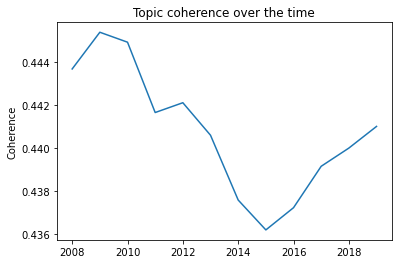

In [35]:
# Print the time evolution of topics coherence
serie = coherence_serie.plot()
plt.title('Topic coherence over the time')
plt.ylabel("Coherence")
plt.savefig('time_coherence.png')

<h2> 3. Find the best dynamic LDA Topic modelling </h2>

In [1]:
# Set a number of Topic
#n_topics = list(range(10,200,10)) 
list(range(10,200,10)) 

# For each number of topics, solve the DTM and compute the global coherence

[10,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190]